# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [17]:
!pip list

Package                      Version
---------------------------- ----------
absl-py                      1.3.0
albumentations               1.3.0
asttokens                    2.1.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.2.0
certifi                      2022.9.24
charset-normalizer           2.1.1
colorama                     0.4.6
contourpy                    1.0.6
cycler                       0.11.0
debugpy                      1.6.3
decorator                    5.1.1
entrypoints                  0.4
executing                    1.2.0
flatbuffers                  22.10.26
fonttools                    4.38.0
gast                         0.4.0
google-auth                  2.14.1
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.50.0
h5py                         3.7.0
idna                         3.4
imageio                      2.22.4
imgviz                       1.6.1
impor

In [10]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data

### 2.1 Load Images

In [12]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [14]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [15]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [16]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [17]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [18]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [19]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images

In [20]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)

train = train.batch(16)
train = train.prefetch(4)

In [21]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [22]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

In [23]:
data_samples = train.as_numpy_iterator()

In [24]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


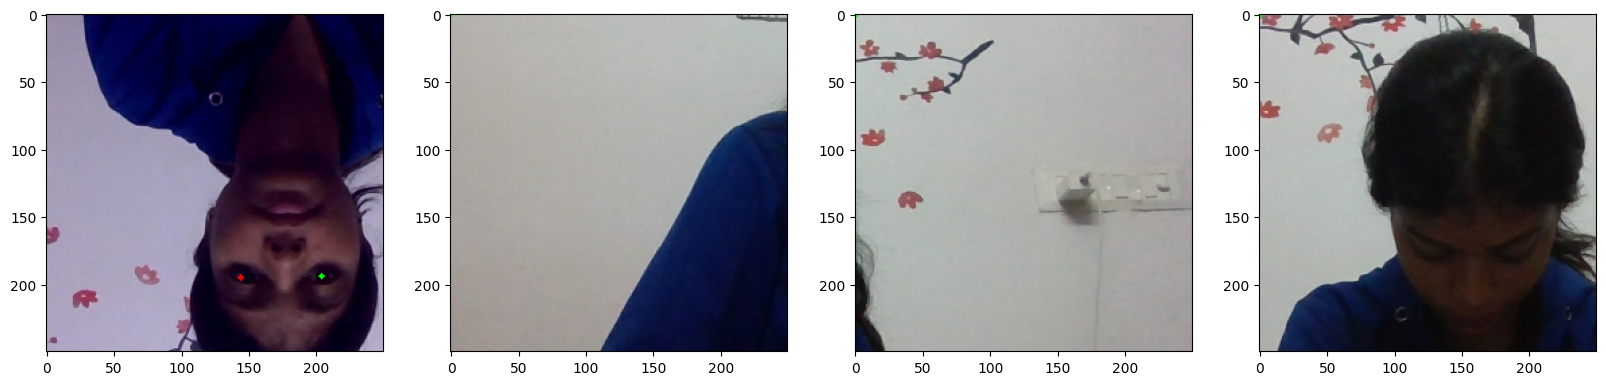

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [27]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [30]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [31]:
X, y = train.as_numpy_iterator().next()

In [32]:
X.shape

(16, 250, 250, 3)

In [33]:
scores = model.predict(X)

1/1 [==============================] - 15s 15s/step


In [34]:
scores

array([[ 0.02797343,  0.63086146,  0.82400584,  0.12047964],
       [ 0.4527916 ,  0.54134446,  0.6774141 ,  0.28680295],
       [ 0.56292313,  0.19331619,  1.6155484 ,  0.7123841 ],
       [ 0.41378278,  0.32000732,  0.43065   , -0.00468318],
       [ 0.7010125 ,  0.64916295,  0.2890876 ,  0.7041265 ],
       [ 0.01123267,  0.10390578,  1.2461401 , -0.1688676 ],
       [ 0.8805052 ,  0.3148993 ,  0.69083846,  0.4175369 ],
       [ 0.46984613,  0.83078367,  1.5975076 ,  0.3656997 ],
       [ 0.14603864,  0.07506516,  0.34468442,  0.09275563],
       [ 0.00947276,  0.56096226,  0.54210436,  1.0316734 ],
       [ 0.67477787, -0.4869534 ,  0.6816845 ,  0.19263354],
       [ 1.0485518 ,  0.13839927,  0.32804453,  0.91910183],
       [ 0.03648333,  0.4288587 ,  0.3011204 ,  0.92454433],
       [ 0.24151248, -0.12753032,  1.235684  ,  0.21335334],
       [ 0.97170377, -0.82612693,  0.5388233 ,  0.2036073 ],
       [-0.01224263,  0.21574855,  0.7358696 , -0.13246223]],
      dtype=float32)

### 3.4 Train the Model

In [ ]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

# 4. Review Performance

### 4.1 View Loss Plots

In [4]:
hist.history

NameError: name 'hist' is not defined

In [35]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

### 4.2. Make Predictions on Test

In [36]:
test_data = test.as_numpy_iterator()

In [37]:
test_sample = test_data.next()

In [38]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 8s 8s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


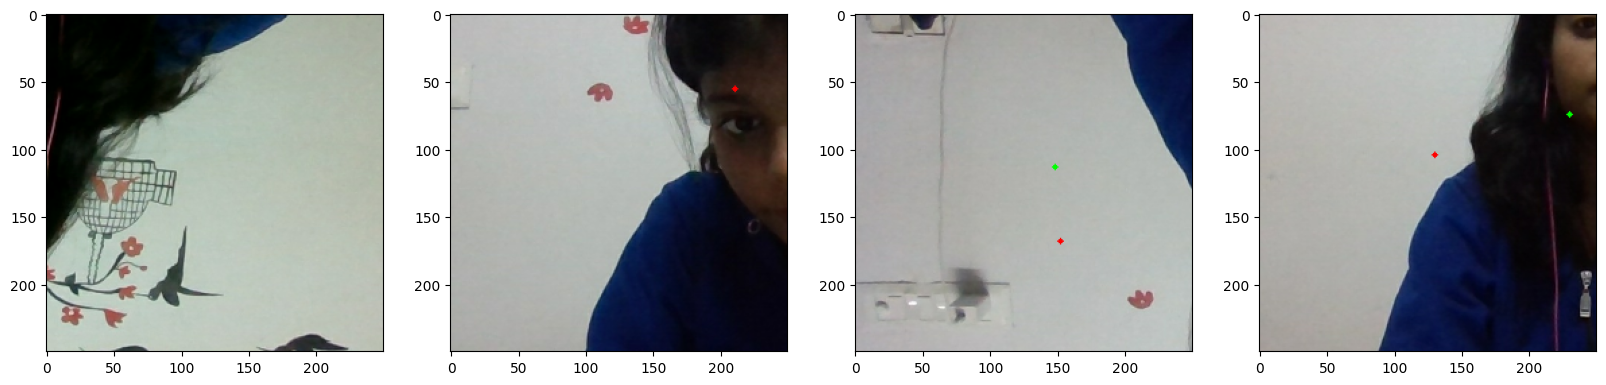

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3. Save the Model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save('eyetrackerresnet.h5')

In [42]:
model = load_model('eyetrackerresnet.h5')

In [43]:
model.predict(test_sample[0])

1/1 [==============================] - 12s 12s/step


array([[ 0.659584  ,  1.3873857 ,  1.6439214 , -0.01287013],
       [ 1.4661983 , -0.24890572,  4.167976  ,  1.2991261 ],
       [ 4.3981447 ,  1.4641415 ,  4.5565634 ,  1.4640274 ],
       [ 4.782183  , -1.8607755 ,  8.262872  ,  0.03396523],
       [ 0.35419768, -0.35021433,  0.55948925,  0.6649704 ],
       [ 0.4314079 , -0.15909714,  2.0208426 ,  0.05274782],
       [ 0.7290732 ,  0.29329872,  0.44009584,  0.7530417 ],
       [ 0.36277783,  0.42829818,  0.6417418 , -0.52249646],
       [ 0.5811543 ,  0.20763026,  0.5794839 ,  0.05103749],
       [-0.00879956,  0.15693465,  0.5118818 ,  0.24062932],
       [ 0.17425995,  0.84111285,  1.2088828 , -0.11449336],
       [ 0.46411362,  0.17011473,  0.09432802,  0.7603166 ],
       [ 0.4562177 ,  0.11700602,  0.30537257,  0.43252018],
       [ 0.07692921,  0.6084171 ,  0.3098211 ,  0.6275254 ],
       [-0.03450641, -0.2720397 ,  1.0055274 ,  0.33248228],
       [ 0.30843735, -0.36085686,  0.74716973, -0.06846274]],
      dtype=float32)

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 744ms/step
